# Implementing Basic Neural Networks with LENGTH

This is the first practical exercise of our course [Applied Edge AI](https://open.hpi.de/courses/edgeai2022).
In this exercise, you are going to implement a few basic functions and library components of neural networks from scratch in Python.

Here is a reminder about the technical limitations on this programming platform:

#### Inactivity and Saving

- After 15 minutes of inactivity the Python kernel shuts down, but the kernel is easy to restart if you continue your work within 60 minutes.
- After 60 minutes of inactivity the data is deleted to free up resources for other users.
- Therefore, please save the notebook locally (click "File" -> "Download") if you are pausing your work on the notebook for more than one hour. (We have put a reminder to save the notebook after each task.)
- If you have to restore your work from a downloaded notebook, press the Upload Button (see image below)
and select your locally saved `.ipynb` file (confirm to overwrite).
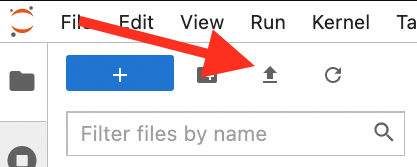

#### Grading

- The grading process relies on the existing cell order.
- Therefore: Do not create new cells and do not delete existing cells in the notebook.
- If you need/want to create new cells in the notebook, you can add them after the grading code.

## Import Libraries

Before we start programming, we are going to import a few libraries in the following code cell:

In [ ]:
import numpy as np

import length.functions as F

import length.tests.optimizer_tests.test_sgd as sgd_tests
import length.tests.layer_tests.test_fully_connected as fc_tests
import length.tests.function_tests.test_mean_squared_error as mse_tests
import length.tests.function_tests.test_relu as relu_tests

from length import constants
from length.data_sets import MNIST, FashionMNIST
from length.function import Function
from length.models import MLP
from length.optimizer import Optimizer

# Task 1: SGD

In [one of the lectures](https://open.hpi.de/courses/edgeai2022/items/7n6K5Xuqmi5Q7Dbb2epHRi) in our course we learned about SGD.
In the following task we want to compute the parameter delta to actually implement SGD.
If you look up the formula on our course slides, the `param_deltas` are subtracted by our framework, thus we do *not* need to multiply our result with -1 in the code.
Also note, that the variable `gradients` is the *list* of computed derivatives, thus the derivative part of the formula is already computed here.

In [ ]:
class SGD(Optimizer):
    """
    An optimizer that does plain Stochastic Gradient Descent
    (https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Iterative_method)
    :param lr: the learning rate to use for optimization
    """

    def __init__(self, lr):
        self.learning_rate = lr

    def run_update_rule(self, gradients, _):
        # :param gradients: a list of all computed gradient arrays
        # :return: a list of deltas for each provided gradient

        # TODO: implement SGD update rule and store the result in a variable called param_deltas (as a list)
        # HINT: it can be solved in a single line with a list comprehension ;)
        # TASK START - Start coding here:
        raise NotImplementedError()
        # TASK END
        return param_deltas

If you want to test your solution, you can execute the following code cell.
If your solution passes our test, it will simply print `Test passed.`
If it does not work, you will get an error.
In this case you need to fix the code above.
(And do not forget to run the above code cell again!)

In [ ]:
sgd_tests.SGD = SGD
sgd_tests.test_sgd()
print("Test passed.")

# Task 2: Fully Connected Layer

*Reminder: before you start working on the next task, it might be a good time to save the notebook locally now (click "File" -> "Download").*

It seems we have not learned a lot about a "fully connected" layer (sometimes also called a "Dense" layer) in our lecture so far.
However we learned about Perceptrons and Multi Layer Perceptrons (MLPs), and fully connected layers are the building block of these early models for machine learning.

They simply store a weight between each possible input and output value and a bias for each output value.
For example, if we have 2 inputs $i_0,i_1$ and 3 outputs $o_0,o_1,o_2$, we store 6 weight values $w_{00}, w_{01}, w_{10}, w_{11}, w_{20},w_{21}$, one value for each pair of one input and one output, and three bias values $b_0,b_1,b_2$, one for each output.
Then during the forward pass the outputs of a fully connected layer are calculated as
$$o_x = \sum_{y=0}^1{(i_y \cdot w_{xy}) + b_x} \text{ for } 0 \leq x < 3.$$
This is simplified for a single element but in a neural network we work with mini-batches (processing a small number of samples at the same time).
In this case, we can use the [dot product](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) of two arrays to simplify this element-wise multiplication.

Here is a small very simple code snippet for the forward pass of our example case above with a batch size of 5.
The batch axis complicates matters slightly, but pay attention to the shape of each array and how the output size changes.
You can play around with different input and output sizes here if you want:

In [ ]:
batch_size = 5
num_inputs = 2
num_outputs = 3

i = np.arange(batch_size * num_inputs).reshape(batch_size, num_inputs)
w = np.arange(num_outputs * num_inputs).reshape(num_outputs, num_inputs)
b = np.zeros(num_outputs)
print(f"Inputs {i.shape}:\n", i)
print(f"Weights {w.shape}:\n", w)
print(f"Bias {b.shape}:\n", b)

output = np.dot(i, w.T) + b
print(f"Output {output.shape}:\n", output)

One interesting fact here can help you with implementing the backward pass:
applying the dot product on two arrays with shapes (5,2) and (2,3) "removes" the common axis with size 2 and results in an array of (5,3).
You can use this knowledge to figure out which arrays need to be transposed to get the correct shape during the *backward* pass.

Furthermore, you can recap how multiplication (between weights and inputs) affects the gradients in our lecture video [Computational Graph](https://open.hpi.de/courses/edgeai2022/items/5MvYzHV8w1UKs2jfu94Pll).
(Remember instead of using simple multiplication we can use the dot product for arrays.)
In the same video you can also recap what happens when we add *two* values in a computational graph (in this case the result of the dot product and our bias), so you can later on implement the *backward* pass for the *bias* correctly.

Also you may have noted, that we *transposed* the weight array in the example above - "swapping" the axes from (3,2) to (2,3) - with numpy before the dot product by calling `.T`.

This is because we recommend storing the weight array in a *transposed* way in your implementation (similar to our example above).

One final hint before you are ready to start implementing: we use the variable name `x` for the inputs (`grad_x` for the gradients with respect to the inputs) in our code below, instead of `i` in the example above (we only used `i` above so it maches the previous formula).

In [ ]:
from length.layer import Layer
from length.constants import DTYPE
from length.initializers.xavier import Xavier


class FullyConnected(Layer):
    """
    The FullyConnected Layer is one of the base building blocks of a neural network. It computes a weighted sum
    over the input, using a weight matrix. It furthermore applies a bias term to this weighted sum to allow linear
    shifts of the computed values.
    """
    name = "FullyConnected"

    def __init__(self, num_inputs, num_outputs, weight_init=Xavier()):
        super().__init__()

        # TODO: initialize our weights with correct shape, using the weight initializer 'weight_init'
        # here are two hints:
        # 1. store an array of zeros in `self._weights` with the correct shape (we recommend storing it transposed as in our simple example above) and use dtype=DTYPE
        # 2. call `weight_init` with our freshly created array `self._weights` to initialize the array properly
        # TASK START - Start coding here:
        raise NotImplementedError()
        # TASK END
        
        # TODO: initialize `self.bias` with an array of zeros in the correct shape and use dtype=DTYPE
        # TASK START - Start coding here:
        raise NotImplementedError()
        # TASK END

    @property
    def weights(self):
        # Transform weights between internal and external representation
        return self._weights.T

    @weights.setter
    def weights(self, value):
        # Transform weights between internal and external representation
        self._weights = value.T

    def internal_forward(self, inputs):
        x, = inputs
        
        # TODO: calculate the output of this layer and store it in a variable `result`
        #       (hint: you can look at our simple example above)
        # TASK START - Start coding here:
        raise NotImplementedError()
        # TASK END
        return result,

    def internal_backward(self, inputs, gradients):
        x, = inputs
        grad_in, = gradients
        
        # TODO: calculate gradients with respect to inputs for this layer
        # 1. calculate and store gradients for (the batch of) the inputs `x` in `grad_x`
        #    (hint: instead of simple multiplication we need to use the dot product for arrays)
        # 2. calculate and store gradients for the weights `w` in `grad_w`
        #    (hint: the shapes of `grad_w` and `self._weights` must be equal, so try to figure out which axes is "removed" by applying the dot product)
        # 3. calculate and store gradients for the bias `b` in `grad_b`
        #    (hint: gradients from multiple sources in the computational graph need to be added up)
        # TASK START - Start coding here:
        raise NotImplementedError()
        # TASK END

        assert grad_x.shape == x.shape
        assert grad_w.shape == self._weights.shape
        assert grad_b.shape == self.bias.shape

        return grad_x, grad_w, grad_b

    def internal_update(self, parameter_deltas):
        delta_w, delta_b = parameter_deltas
        
        # TODO: apply updates to weights (self._weights) and bias (self.bias) according to deltas from optimizer
        # if you remember our instructions on how to implement SGD, we said: "[...] the param_deltas are subtracted by our framework [...]"
        # so this is all we need to do here.
        # TASK START - Start coding here:
        raise NotImplementedError()
        # TASK END

If you want to test your solution, you can execute the following code cell.
If your solution passes our test, it will simply print `Test passed.`
If it does not work, you will get an error.
In this case you need to fix the code above.
(And do not forget to run the above code cell again!)

In [ ]:
fc_tests.FullyConnected = FullyConnected
fc_tests.test_initialization()
fc_tests.test_fully_connected_forward()
fc_tests.test_fully_connected_backward()
print("Test passed.")

# Task 3: Mean Squared Error

*Reminder: before you start working on the next task, it might be a good time to save the notebook locally now (click "File" -> "Download").*

To train a model, we also need a loss function.
These loss functions mathematically define how our model should be optimized (and thus learn to solve a certain task).

A very simple loss function, which still can be effective in training models is the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error).
Therefore in the following task, we are going to implement this function.
The corresponding [wikipedia article](https://en.wikipedia.org/wiki/Mean_squared_error) should explain everything you need to know, if you are not yet familiar with the function.

In [ ]:
class MeanSquaredError(Function):
    """
    This function calculates the Mean Squared Error between two given vectors, as described in
    https://en.wikipedia.org/wiki/Mean_squared_error
    """
    name = "MeanSquaredError"

    def __init__(self):
        super().__init__()
        # TODO: add more initialization if necessary
        # TASK START - Start coding here:
        raise NotImplementedError()
        # TASK END

    @staticmethod
    def create_one_hot(data, shape):
        assert len(shape) == 2, "Providing integers as second input to MSE only works with two dimensional input vectors"
        # TODO: create a one-hot representation out of the given label vector (with dtype=DTYPE)
        # Example: assume `data` is [2, 3, 0], and the desired `shape` is (3, 4)
        #          in this case we have 4 possible classes and 3 samples, belonging to class 2, class 3, and class 0 
        #          therefore we need to set a 1 at position 2, 3, 0 for each sample respectively
        #          the resulting vector should look like this:
        #          result = [[0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0]]
        # Hint: initialize an array of zeros with the given `shape`, set 1s where needed and in the end return your created array
        # TASK START - Start coding here:
        raise NotImplementedError()
        # TASK END

    def internal_forward(self, inputs):
        x1, x2 = inputs

        if np.issubdtype(x2.dtype, np.integer):
            x2 = self.create_one_hot(x2, x1.shape)

        # TODO: calculate the mean squared error of x1 and x2 and store the result in `mean_squared_error`
        # hint: you can store an intermediate result as a class member variable here that you need during the backward pass
        # TASK START - Start coding here:
        raise NotImplementedError()
        # TASK END
        
        return mean_squared_error.astype(DTYPE),

    def internal_backward(self, inputs, gradients):
        x1, x2 = inputs
        gx, = gradients
        
        # TODO: calculate the gradients of this function with respect to its (two) inputs
        # (hint: the derivative depends on the inputs (here you could use an intermediate 
        #        result from the forward pass) and the size of the inputs)
        # TASK START - Start coding here:
        raise NotImplementedError()
        # TASK END

        if np.issubdtype(x2.dtype, np.integer):
            # in case we used MSE as loss function, we won't propagate any gradients to the loss
            return gradient_1, None

        return gradient_1, gradient_2


def mean_squared_error(input_1, input_2):
    """
    This function calculates the Mean Squared Error between input_1 and input_2. Both inputs should be vectors of the
    same shape. You can also supply a one-dimensional list of integers.
    If you do so this vector will be converted to a one_hot representation that fits to the shape of the second
    input
    :param input_1: the first vector of any shape
    :param input_2: the second vector. Needs to have the same shape as the first vector, or be a one-dimensional int vector
    :return: the mean squared error between input_1 and input_2
    """
    return MeanSquaredError()(input_1, input_2)

If you want to test your solution, you can execute the following code cell.
If your solution passes our test, it will simply print `Test passed.`
If it does not work, you will get an error.
In this case you need to fix the code above.
(And do not forget to run the above code cell again!)

In [ ]:
mse_tests.MeanSquaredError = MeanSquaredError
mse_tests.mean_squared_error = mean_squared_error
mse_tests.test_mean_squared_error_forward_zero_loss()
mse_tests.test_mean_squared_error_forward_loss()
mse_tests.test_mean_squared_error_forward_int_input()
mse_tests.test_mean_squared_error_backward()
mse_tests.test_mean_squared_error_backward_with_label()
print("Test passed.")

# Task 4: ReLU (Rectified Linear Unit)

*Reminder: before you start working on the next task, it might be a good time to save the notebook locally now (click "File" -> "Download").*

In our course we learned about how the ReLU function helped to solve the problem of vanishing gradients in the video [A Concise History of Neural Networks (3/4)](https://open.hpi.de/courses/edgeai2022/items/1MFgZMXTuuMCOtoF1zghEv).

In the next task, we are going to implement this function by filling in the missing forward and backward pass.

In [ ]:
class Relu(Function):
    """
    The Relu Layer is a non-linear activation
    """
    name = "ReLU"

    def __init__(self):
        super().__init__()
        # TODO: add more initialization of class member variables if necessary
        # TASK START - Start coding here:
        raise NotImplementedError()
        # TASK END

    def internal_forward(self, inputs):
        x, = inputs
        # TODO: calculate forward pass of ReLU function and store it in `activated_inputs`
        # (we can store any variables we need for the calculation of the backward pass in a class member variable here as well)
        # TASK START - Start coding here:
        raise NotImplementedError()
        # TASK END
        return activated_inputs,

    def internal_backward(self, inputs, gradients):
        x, = inputs
        grad_in, = gradients
        
        # TODO: calculate gradients of ReLU function with respect to the input and store it in grad_x
        # you can first calculate the derivative of ReLU itself (hint: it depends on the input of the forward pass)
        # and then use element-wise multiplication of the calculated derivative with the `grad_in` gradients
        # TASK START - Start coding here:
        raise NotImplementedError()
        # TASK END
        
        assert grad_x.shape == x.shape
        return grad_x,


def relu(x):
    """
    This function computes the element-wise ReLU activation function (https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
    on a given input vector x.
    :param x: the input vector
    :return: a rectified version of the input vector
    """
    return Relu()(x)

If you want to test your solution, you can execute the following code cell.
If your solution passes our test, it will simply print `Test passed.`
If it does not work, you will get an error.
In this case you need to fix the code above.
(And do not forget to run the above code cell again!)

In [ ]:
relu_tests.relu = relu
relu_tests.Relu = Relu
relu_tests.test_relu_forward()
relu_tests.test_relu_backward()
print("Test passed.")

# Grading Tasks 1-4

*Reminder: before you start grading the tasks, it might be a good time to save the notebook locally as well (click "File" -> "Download").*

Please follow these instructions before you run the below code cell to grade the tasks 1 through 4:

- Check that you have not modified the **Test case** code cells.
- Check that you have **not created** new cells and **not deleted** existing cells in this notebook. (Otherwise the grading process might fail despite you having the correct solution, since it depends on the original order of notebook cell.)
- Save (CTRL + S) your notebook everytime you want to have your tasks graded, the grader uses the last saved version.

If have done all the above, run the code cell below to run the grading process.
Once that is done, click the "Submit Assignment" button and confirm your submission.

In [ ]:
!python3 grader.pyc
%run -i .button.py

# Building a MultiLayerPerceptron (MLP)

After you have clicked the "Submit Assignment" button above, your grade of tasks 1 to 4 should show up in the openHPI course.

Now we have implemented all the building blocks required to build and train a MultiLayerPerceptron.
There is nothing that needs to be done in the following code cells, but feel free to explore the code, especially how our layers are initialized in the `__init__` function, and how they are used during the forward pass.

Also you can see how our functions (`relu` and `mean_squared_error`) are used, but they do not need initialization or saving, since they - in contrast to our `FullyConnected` layers - store no weights .

We only need to save the output of our loss function in `self.loss` to be able to calculate gradients in the backward pass.

In [ ]:
class ActivatedMLP:
    
    def __init__(self):
        self.fully_connected_1 = FullyConnected(784, 512)
        self.fully_connected_2 = FullyConnected(512, 512)
        self.fully_connected_3 = FullyConnected(512, 10)

        self.loss = None
        self.predictions = None
    
    def forward(self, batch, train=True):
        hidden = relu(self.fully_connected_1(batch.data))
        hidden = relu(self.fully_connected_2(hidden))
        self.predictions = self.fully_connected_3(hidden)
        self.loss = mean_squared_error(self.predictions, batch.labels)
        
    def backward(self, optimizer):
        self.loss.backward(optimizer)

# Train Loop

Now we still need a training loop implementation.
We have provided one below (you do not need to change the code), but you should try to understand the concepts of what is happening there.

(Next week, we are going to implement our own training loop with PyTorch in the exercise. It is going to look slightly different.)

In [ ]:
def train_loop(args, data_set, model, optimizer):
    for epoch in range(args.num_epochs):
        # train our model
        for iteration, batch in enumerate(data_set.train):
            model.forward(batch)
            model.backward(optimizer)

            if iteration % args.train_verbosity == 0:
                accuracy = F.accuracy(model.predictions, batch.labels).data
                print("train: epoch: {: 2d}, loss: {: 5.2f}, accuracy {:.2f}, iteration: {: 4d}".
                      format(epoch, model.loss.data, accuracy, iteration), end="\r")
        
        # test our model
        print("\nrunning test set...")
        sum_accuracy = 0.0
        sum_loss = 0.0
        for iterations, batch in enumerate(data_set.test):
            model.forward(batch, train=False)
            sum_accuracy += F.accuracy(model.predictions, batch.labels).data
            sum_loss += model.loss.data
        nr_batches = iterations - 1
        print(" test: epoch: {: 2d}, loss: {: 5.2f}, accuracy {:.2f}".
              format(epoch, sum_loss / nr_batches, sum_accuracy / nr_batches))
        
        # a very simple update rule for the learning rate, reduce it by a factor of 10 after the first and the fourth epoch
        # do *not* change this if you want to solve our bonus task (otherwise it will change the expected results)
        if epoch % 3 == 0:
            optimizer.learning_rate *= 0.1

# Running the Training

Finally, we can train our MLP.
We have provided code to load two datasets [MNIST](http://yann.lecun.com/exdb/mnist/) and [FasionMNIST](https://github.com/zalandoresearch/fashion-mnist).
The first one classifies handwritten digits in grayscale images, the latter one classifies items of clothing based on grayscale images.

Since these datasets are extremely small, we can even train our model on CPU and it should not take longer than a few minutes.
You should be able to simply run the code below right now.
Note, how the train and test accuracy changes during the training process.

Training with the default settings (using our implemented SGD optimizer starting with a learning rate of 0.1) our MLP on MNIST should achieve about 0.78 (78%) **test** accuracy after 5 epochs of training.

If you implement the Adam optimizer in the bonus task at the end of this notebook, you need to edit the code below to enable training with it, look for the instructions in the comments after each line starting with `# BONUS TASK ADAM`.

In [ ]:
import argparse
import os


def main(args):
    args.check()

    data_set = None
    if args.data_set == "mnist":
        data_set = MNIST(args.batch_size)
    if args.data_set == "fashion":
        data_set = FashionMNIST(args.batch_size)

    optimizer = None
    if args.optimizer == "adam":
        # BONUS TASK ADAM: if you implemented Adam below (and ran that code cell), then remove or comment the next line...
        raise NotImplementedError("Adam not implemented yet.")
        # ... and uncomment the following line:
        #optimizer = Adam(args.learning_rate)
    if args.optimizer == "sgd":
        optimizer = SGD(args.learning_rate)

    model = ActivatedMLP()

    train_loop(args, data_set, model, optimizer)

class TrainOptions:
    # do not change these values, rather set other values below before calling the main function
    num_epochs      = 5       # number of epochs
    batch_size      = 64      # batch size
    optimizer       = "sgd"   # adam or sgd
    data_set        = "mnist" # which dataset we want to train for
    learning_rate   = 0.1     # learning rate
    train_verbosity = 50      # how often to print the training accuracy

    def check(self):
        assert self.optimizer in ["adam", "sgd"]
        assert self.data_set in ["mnist", "fashion"]

options = TrainOptions()

# BONUS TASK ADAM: uncomment the following lines if you have implemented adam and you should be able to reach 99% test accuracy on MNIST after one or two epochs
#options.optimizer="adam"
#options.learning_rate = 0.001
# BONUS TASK ADAM: after you trained a model on MNIST, you can change the dataset to FashionMNIST and train another MLP to answer our graded bonus quiz
#options.data_set = "fashion"

main(options)
print("Training finished.")

# What now?

Now you should have implemented a few basic functions of a neural network from scratch.
We hope this has provided you with a deeper knowledge of how neural network layers are implemented and how the models can be constructed and trained.

You can now experiment a bit more with the options given above, for example:

* try to choose a different learning rate and see how it affects the training and testing accuracy
* train a model for the more challenging FashionMNIST dataset
* train for a few more epochs and see if you can achieve a higher accuracy
* try a different learning rate update rule in the training loop implementation

Make sure you attempt to complete all four tasks to the best of your abilities, as we will have questions in the graded quiz which relate to this exercise.

You can also attempt our bonus task below.

# Optional Bonus Task: Adam

*Reminder: before you start working on the bonus task, it might be a good time to save the notebook locally now (click "File" -> "Download").*

In this task (which is completely optional and a bit more challenging - but at the same time highly rewarding if you manage to complete it) you can implement the famous Adam optimizer yourself.
This optimizer was first proposed in an [arxiv preprint](https://arxiv.org/abs/1412.6980) in 2014.

It is popular because it is less sensitive to choosing a suitable learning rate, and many improvements to the original implementation have since been found.
You can absolutely implement the optimizer based on the original paper linked above, but of course you are welcome to find additional sources and explanations online if you encounter difficulties.

## Mathematics and Programming

To highlight the mathematical side of deep learning we present a possible mathematical reformulation when updating the biased first moment estimates in the following.
The original paper suggests the formula:

$$m_t \leftarrow \beta_1\cdot m_{t-1} + (1-\beta_1) \cdot g_t$$

However we can simplify the equation on the right side by adding a "zero" ($m_{t-1} - m_{t-1}=0$)
$$m_t \leftarrow m_{t-1} - m_{t-1} + \beta_1 \cdot m_{t-1} + (1-\beta_1) \cdot g_t$$
This allows us to factor out $-m_{t-1}$
$$m_t \leftarrow m_{t-1} - m_{t-1} \cdot (1-\beta_1) + (1-\beta_1) \cdot g_t$$
and also factor out $(1-\beta_1)$:
$$m_t \leftarrow m_{t-1} + (1-\beta_1) \cdot (g_t - m_{t-1})$$

This may not look simpler until we realize this allows us to use the `+=` operator in Python pseudocode:
```
m += (1 - self.beta1) * (g - m)
```
Similarly the second raw moment estimate update can be reformulated to

$$v_t \leftarrow v_{t-1} + (1-\beta_2) \cdot (g_t^2 - v_{t-1})$$

which in Pseudocode can be written as `v += (1 - self.beta2) * (g * g - v)`.


In [ ]:
class Adam(Optimizer):
    """
    The Adam optimizer (see https://arxiv.org/abs/1412.6980)
    :param learning_rate: initial step size
    :param beta1: Exponential decay rate of the first order moment
    :param beta2: Exponential decay rate of the second order moment
    :param eps: Small value for numerical stability
    """

    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # map from layer id to a list of numpy arrays
        self.m_values = {}
        self.v_values = {}
        # map from layer id to int (time step)
        self.t_values = {}

        self.current_id = -1
        self._initialized = set()

    def run_update_rule(self, gradients, layer):
        param_deltas = []
        
        self.current_id = id(layer)

        if not self.initialized:
            self.initialize(gradients)
            
        # TODO: Implement Adam Update Rule, save result in variable param_deltas and return
        # (for this bonus task you need to figure out the implementation details of Adam for yourself)
        # hint: self.m_values contains a *list* of "m_{t-1}" arrays (exactly one value with the correct shape for each gradient in the `gradients` list)
        # TASK START - Start coding here:
        raise NotImplementedError()
        # TASK END
        return param_deltas

    def initialize(self, gradients):
        self.m_values[self.current_id] = [np.zeros_like(gradient) for gradient in gradients]
        self.v_values[self.current_id] = [np.zeros_like(gradient) for gradient in gradients]
        self.t_values[self.current_id] = 0
        self._initialized.add(self.current_id)

    @property
    def initialized(self):
        return self.current_id in self._initialized

If your Adam implemenation is correct you should be able to achieve about .99 **test** accuracy on **MNIST** after the **first** or **second** epoch (with a learning rate of 0.001).

*Reminder: it might be a good time to save the notebook locally now for one final time, since you need the training results for answering the bonus quiz (click "File" -> "Download").*

Edit the code cell in the section "Running the Training" to test this (look for the lines with comments containing `# BONUS TASK ADAM`).

If your implementation is correct you can gain 2 bonus points for completing our [bonus quiz](https://open.hpi.de/courses/edgeai2022/items/2FiAK0BMrxsJPRaufpENNK) of this week.

Before you attempt the quiz, you should train an MLP on **FashionMNIST** with Adam with the same settings (you need to uncomment another line in the training code to change the dataset - keep the learning rate of 0.001).